In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

**Loading The Data**

In [45]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
targets = train['target']
train = train.drop(columns=['id', 'target'])
ids = test['id']
test = test.drop(columns=['id'])

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(train.values)
trans_x = transformer.transform(train.values)
trans_test = transformer.transform(test.values)

**Principal Component Analysis**

First I am going to use PCA to reduce colinearity in the data, I am going to try a range of values for dimensionality reduction and use the best performing through testing with K fold cross validation

0.752


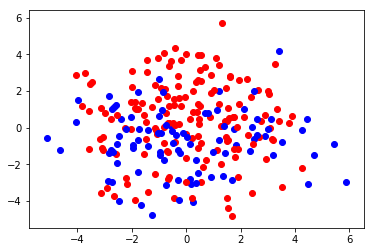

In [46]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
scores = []
param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
                "penalty": ('l1','l2')}
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
gs = GridSearchCV(clf, param_grid, cv=5)
gs.fit(trans_x, targets)

best_score = gs.best_score_
best_estimator = gs.best_estimator_
best_pca = 'N/a'
print(best_score)
"""
for i in range(10,250, 10):
    pca = PCA(n_components=i)
    pca.fit(train.values)
    
    X = pca.transform(trans_x)
    transformed_test = pca.transform(test.values)
    #Find the best model for these components
    param_grid = {"C": [.01, .1, 1, 10, 100, 1000],
                "penalty": ('l1','l2')}
    clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
    gs = GridSearchCV(clf, param_grid, cv=5)
    gs.fit(X, targets)
    print("Best Score for : ", str(i), " is ", str(gs.best_score_))
    scores.append(gs.best_score_)
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_estimator = gs.best_estimator_
        best_pca = i
print("Best score was : ", str(best_score), " with estimator ", str(best_estimator), ' \n and PCA : ', str(best_pca))"""
pca = PCA(n_components=2)
pca.fit(train.values)
vals_2d = pca.transform(train.values)
import matplotlib.pyplot as plt
colors = ['red' if t == 1 else 'blue' for t in targets]
for i in range(len(vals_2d)):
    plt.scatter(x=vals_2d[i,0], y=vals_2d[i,1], color=colors[i])


**t-SNE**

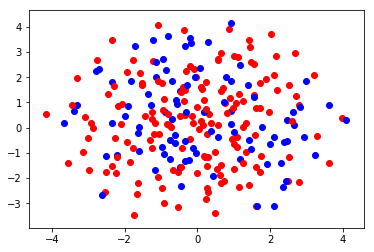

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
vals_2d = tsne.fit_transform(train.values)
import matplotlib.pyplot as plt
colors = ['red' if t == 1 else 'blue' for t in targets]
for i in range(len(vals_2d)):
    plt.scatter(x=vals_2d[i,0], y=vals_2d[i,1], color=colors[i])


PCA actually seems to be negatively affecting the model across the board... oops

**RFE**

In [48]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate
selector = RFECV(best_estimator, step=1, cv=5)
selector = selector.fit(trans_x, targets)
new_trans_x = selector.transform(trans_x)
new_trans_test = selector.transform(trans_test)


**Try Reduction Now With Only The Selected/Transformed Components**

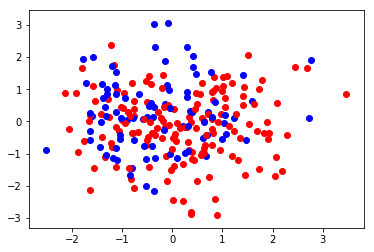

In [49]:
pca = PCA(n_components=2)
pca.fit(new_trans_x)
vals_2d = pca.transform(new_trans_x)
import matplotlib.pyplot as plt
colors = ['red' if t == 1 else 'blue' for t in targets]
for i in range(len(vals_2d)):
    plt.scatter(x=vals_2d[i,0], y=vals_2d[i,1], color=colors[i])
    


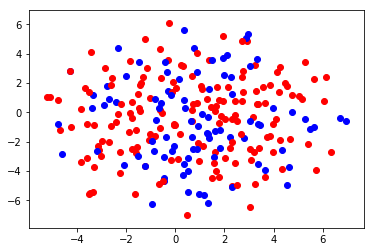

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
vals_2d = tsne.fit_transform(new_trans_x)
import matplotlib.pyplot as plt
colors = ['red' if t == 1 else 'blue' for t in targets]
for i in range(len(vals_2d)):
    plt.scatter(x=vals_2d[i,0], y=vals_2d[i,1], color=colors[i])

These are not very good visualizations :I

**Predict With Best Model**


In [55]:

param_grid = {"C": [.01, .1],
                "penalty": ('l1','l2')}
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter = 1000)
gs = GridSearchCV(clf, param_grid, cv=5)
gs.fit(new_trans_x, targets)
print(gs.best_estimator_)
print(gs.best_score_)
print(gs.score(new_trans_x, targets))
predictions = gs.predict_proba(new_trans_test)[:,1]

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.956
1.0


**Write Out Predictions**



In [56]:
output = pd.DataFrame({'id' : ids, 'target' : predictions})
output.to_csv('output.csv',index=None)